In [1]:
!pip install -q torchaudio transformers torch datasets


In [2]:
import os
import torchaudio
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import numpy as np
from tqdm.notebook import tqdm  # optimized for notebook display
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer


In [3]:
asr_tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
asr_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
asr_model.eval()

cola_tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-CoLA")
cola_model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-CoLA")
cola_model.eval()

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [4]:
def load_audio(file_path):
    """Loads and preprocesses audio: mono conversion and resampling to 16kHz."""
    try:
        waveform, sample_rate = torchaudio.load(file_path)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)
        return waveform, 16000
    except Exception as e:
        raise RuntimeError(f"Could not load audio: {file_path} -> {e}")

In [5]:
def transcribe_audio(file_path):
    """Transcribes speech from audio file to text using wav2vec2."""
    waveform, sample_rate = load_audio(file_path)
    input_values = asr_tokenizer(waveform.squeeze().numpy(), return_tensors="pt", padding="longest").input_values
    with torch.no_grad():
        logits = asr_model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = asr_tokenizer.batch_decode(predicted_ids)[0]
    return transcription.lower()

In [6]:
def get_grammar_issues(text):
    """Uses LanguageTool API to return grammar issue count."""
    if not text.strip():
        return 0, []
    try:
        response = requests.post("https://api.languagetool.org/v2/check", data={"text": text, "language": "en-US"})
        matches = response.json().get("matches", [])
        return len(matches), matches
    except Exception as e:
        print(f"LanguageTool API error: {e}")
        return 0, []

def compute_score(text, issue_count):
    """Calculates grammar score based on number of issues per word."""
    word_count = max(len(text.split()), 1)
    return round(max(0, 100 - (issue_count / word_count * 100)), 2)

def grammar_acceptability(text):
    """Uses CoLA BERT model to estimate grammatical acceptability."""
    inputs = cola_tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        prob = torch.softmax(cola_model(**inputs).logits, dim=1)
    return round(prob[0][1].item() * 100, 2)

In [7]:
audio_folder = "/kaggle/input/speaker-recognition-audio-dataset/50_speakers_audio_data/Speaker0026" 
wav_files = [f for f in os.listdir(audio_folder) if f.endswith(".wav")]
print(f"Found {len(wav_files)} .wav files:", wav_files[:5])

results = []

for file_name in tqdm(wav_files, desc="Processing Files"):
    file_path = os.path.join(audio_folder, file_name)
    try:
        text = transcribe_audio(file_path)
        issue_count, _ = get_grammar_issues(text)
        results.append({
            'filename': file_name,
            'transcription': text,
            'grammar_errors': issue_count,
            'grammar_score': compute_score(text, issue_count),
            'acceptability_score': grammar_acceptability(text)
        })
    except Exception as e:
        print(f"Failed processing {file_name}: {e}")

Found 45 .wav files: ['Speaker26_044.wav', 'Speaker26_034.wav', 'Speaker26_042.wav', 'Speaker26_039.wav', 'Speaker26_043.wav']


Processing Files:   0%|          | 0/45 [00:00<?, ?it/s]

,filename,transcription,grammar_errors,grammar_score,acceptability_score
0,Speaker26_044.wav,freedom endo sectioned two,1,75.00,7.23
1,Speaker26_034.wav,trangers should avoid those who quarrel among ...,10,93.15,36.39
2,Speaker26_042.wav,if you go on in this way you will soon destroy...,2,98.69,63.10
3,Speaker26_039.wav,used them every one at this moment she tossed ...,7,95.07,22.31
4,Speaker26_043.wav,n us the shepherd and the wolf a shepherd once...,4,97.20,32.80


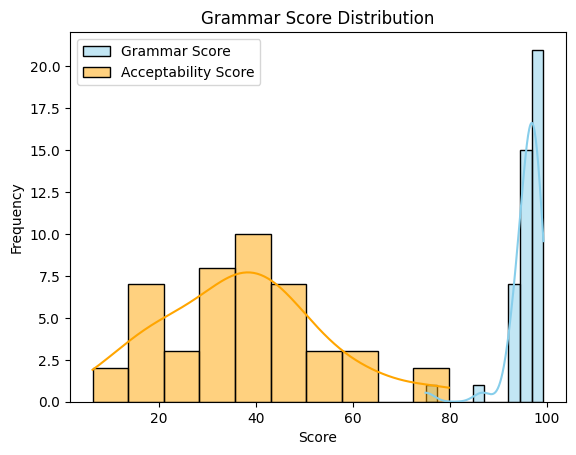

In [8]:
df = pd.DataFrame(results)

if df.empty:
    print("No valid audio files processed or results were empty.")
else:
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['grammar_score', 'acceptability_score'], inplace=True)
    df.to_csv("grammar_scores.csv", index=False)
    display(df.head())

    sns.histplot(df['grammar_score'], bins=10, color='skyblue', label='Grammar Score', kde=True)
    sns.histplot(df['acceptability_score'], bins=10, color='orange', label='Acceptability Score', kde=True)
    plt.title("Grammar Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()